# BAYER - Proyecto de Tableros e Indicadores

## 1) Generar Conexión con SQL SERVER

In [1]:
import requests
import pandas as pd
import datetime
import json

In [2]:
# CONECTAR con SERVIDOR SQL SERVER

import pyodbc
from dotenv import dotenv_values

secrets = dotenv_values(".env")
local_secrets = dotenv_values(".env.dev")

SERVER = secrets["SERVIDOR"]
DATABASE = secrets["DATABASE"]
USERNAME = secrets["USUARIO"]
PASSWORD = secrets["CONTRASENA"]
PORT = secrets["PUERTO"]
DRIVER = secrets["DRIVER"]
OPTIONS= secrets["OPTION"]

connectionString = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD};{OPTIONS}'
print(connectionString)
conn = pyodbc.connect(connectionString) 

#    DRIVER={ODBC Driver 18 for SQL Server};SERVER=213.134.40.73,9595;DATABASE=seamtrack;UID=eduardo.ettlin@vigiloo.com.ar;PWD=Aladelta10$;encrypt=no
#    DRIVER={ODBC Driver 18 for SQL Server};SERVER=username;DATABASE=secret;UID=eduar;PWD=Aladelta10$;encrypt=no

DRIVER={ODBC Driver 17 for SQL Server};SERVER=213.134.40.73,9595;DATABASE=seamtrack;UID=eduardo.ettlin@vigiloo.com.ar;PWD=Aladelta10$;encrypt=no


In [3]:
print(secrets)

OrderedDict({'DRIVER': '{ODBC Driver 17 for SQL Server}', 'SERVIDOR': '213.134.40.73,9595', 'PUERTO': '9595', 'DATABASE': 'seamtrack', 'USUARIO': 'eduardo.ettlin@vigiloo.com.ar', 'CONTRASENA': 'Aladelta10$', 'OPTION': 'encrypt=no'})


## 2) Extraerlos Datos procesados que están en SQL SERVER

In [4]:
# Armar la Consulta con sus PARAMETROS

LIMITE ="'2025-01-01'"

SQL_QUERY = f"""
SELECT  DISTINCT     
    A.[RefId] as EMBARQUE
    ,D.RefId as DELIVERY
    ,A.[Date] as FECHA
    ,F.[Date] as FECHA_ACT

    --,F.[DriverId]
    --,R.[DriverId]
    ,R.[CustomerId]
    ,R.[FirstName]
    ,R.[LastName]
    ,R.[DocumentNumber]
    ,R.[PhonePersonalMobile]
    ,R.[PhoneWorkMobile]

    --,F.[VehicleMotorId]
    ,V.[Plate]
    ,V.[TargetAssignedId]

    ,F.[ActivityStarted]
    ,F.[ActivityStartedAt]
    ,F.[ActivityEndedAt]

    ,G.[Order]
    ,G.[FreeOrder]
    ,G.[TaskStarted]
    ,G.[TaskStartedAt]

    -- ,G.[ThirdLocationId]
    ,G.[LocationEstimatedArrival]

    --,D.[PurchaseDoc]
    ,D.[PurchaseOrderIdRef] as PEDIDO
    ,D.[DestinationCode]
    ,D.[DestinationName]

    ,A.[LogisticGroupId]

    FROM [seamtrack].[vigiloo].[Shipment] A  
    LEFT JOIN [seamtrack].[vigiloo].[ShipmentDestination] B
    ON B.[ShipmentId] = A.Id

    LEFT JOIN [seamtrack].[vigiloo].[Delivery] D
    ON D.[ShipmentId] = A.Id

    LEFT JOIN [seamtrack].[vigiloo].[Activity] F
    ON F.[IdRef] = A.[RefId]
    LEFT JOIN [seamtrack].[vigiloo].[ActivityTask] G
    ON G.[ActivityId] = F.[Id]
    LEFT JOIN [seamtrack].[vigiloo].[Vehicle] V
    ON V.[Id] = F.[VehicleMotorId]
    LEFT JOIN [seamtrack].[vigiloo].[Driver] R
    ON R.[Id] = F.[DriverId]
WHERE A.[Date] >= {LIMITE}
ORDER BY A.RefId,D.RefId, D.[DestinationCode];
"""


In [ ]:
print(SQL_QUERY)

In [5]:
# Ejecutar la Consulta
cursor = conn.cursor()
cursor.execute(SQL_QUERY)
records = cursor.fetchall()

In [6]:
# Generar DATAFRAME con los resultados de las consultas
df = pd.DataFrame((tuple(t) for t in records)) 
df.columns = ['EMBARQUE','DELIVERY','FECHA','FECHA_ACT','CustomerId','FirstName','LastName','DocumentNumber','PhonePersonalMobile','PhoneWorkMobile',
              'Plate','TargetAssignedId','ActivityStarted','ActivityStartedAt','ActivityEndedAt','Order','FreeOrder','TaskStarted','TaskStartedAt','LocationEstimatedArrival',
              'PEDIDO','DestinationCode','DestinationName','LogisticGroupId']

# Eliminar Registros con datos Nulos
df.dropna(subset=['EMBARQUE','DELIVERY'], inplace=True)

# Adecuar el Grupo Logístico
df["LogisticGroupId"] = df["LogisticGroupId"].replace(
    { "75247427-34FD-41A3-B7E0-F0B8312EADA8": "Monsanto", "F21EE1F9-4823-42B4-AD40-8C81F2847818": "BAYER", "B5F0D86E-DD9E-49C7-A55E-F3B0CE3300B4": "Semillas" })  

# Dimensión Fecha
df['Fecha_Corta']= df['FECHA'].dt.strftime('%Y/%m/%d')
df['Anio_Mes']= df['FECHA'].dt.strftime('%Y-%m')  # Agrupo Mensual
df['Semana']= df['FECHA'].dt.strftime('%w') # Atrupo Semanal

In [7]:
df.head(5)

,EMBARQUE,DELIVERY,FECHA,FECHA_ACT,CustomerId,FirstName,LastName,DocumentNumber,PhonePersonalMobile,PhoneWorkMobile,...,TaskStarted,TaskStartedAt,LocationEstimatedArrival,PEDIDO,DestinationCode,DestinationName,LogisticGroupId,Fecha_Corta,Anio_Mes,Semana
0,834717766,8480773271,2025-01-02 09:00:00,NaT,NaN,None,None,None,None,None,...,None,NaT,NaT,8450225063,0003783492,AGROLATINA S.R.L,BAYER,2025/01/02,2025-01,4
1,834717766,8480774157,2025-01-02 09:00:00,NaT,NaN,None,None,None,None,None,...,None,NaT,NaT,8450226601,0004425645,R Y K SRL,BAYER,2025/01/02,2025-01,4
2,834717766,8480774395,2025-01-02 09:00:00,NaT,NaN,None,None,None,None,None,...,None,NaT,NaT,8450226992,0000966081,DEKANOR SRL,BAYER,2025/01/02,2025-01,4
3,834717766,8480774397,2025-01-02 09:00:00,NaT,NaN,None,None,None,None,None,...,None,NaT,NaT,8450227043,0003651992,ERRE SEMILLAS SRL,BAYER,2025/01/02,2025-01,4
4,834718051,8480774452,2025-01-01 17:00:00,NaT,NaN,None,None,None,None,None,...,None,NaT,NaT,8470212139,0004378540,CYAGRO SA,BAYER,2025/01/01,2025-01,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27888 entries, 0 to 27888
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   EMBARQUE                  27888 non-null  object        
 1   DELIVERY                  27888 non-null  object        
 2   FECHA                     27888 non-null  datetime64[ns]
 3   FECHA_ACT                 27338 non-null  datetime64[ns]
 4   CustomerId                27338 non-null  float64       
 5   FirstName                 27338 non-null  object        
 6   LastName                  27338 non-null  object        
 7   DocumentNumber            25850 non-null  object        
 8   PhonePersonalMobile       25584 non-null  object        
 9   PhoneWorkMobile           18692 non-null  object        
 10  Plate                     27338 non-null  object        
 11  TargetAssignedId          27338 non-null  float64       
 12  ActivityStarted        

In [9]:
# GENERAR Dataframes con las Medidas
df_embarque = df.groupby('Fecha_Corta')['EMBARQUE'].nunique()
df_delivery = df.groupby('Fecha_Corta')['DELIVERY'].nunique()
df_pedido = df.groupby('Fecha_Corta')['PEDIDO'].nunique()

# CONTATENAR Dataframes
df_completo = pd.merge(df_embarque, df_delivery, on='Fecha_Corta', how = 'outer')
df_completo = pd.merge(df_completo, df_pedido, on='Fecha_Corta', how = 'outer')

df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 2025/01/01 to 2025/02/17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   EMBARQUE  34 non-null     int64
 1   DELIVERY  34 non-null     int64
 2   PEDIDO    34 non-null     int64
dtypes: int64(3)
memory usage: 1.1+ KB


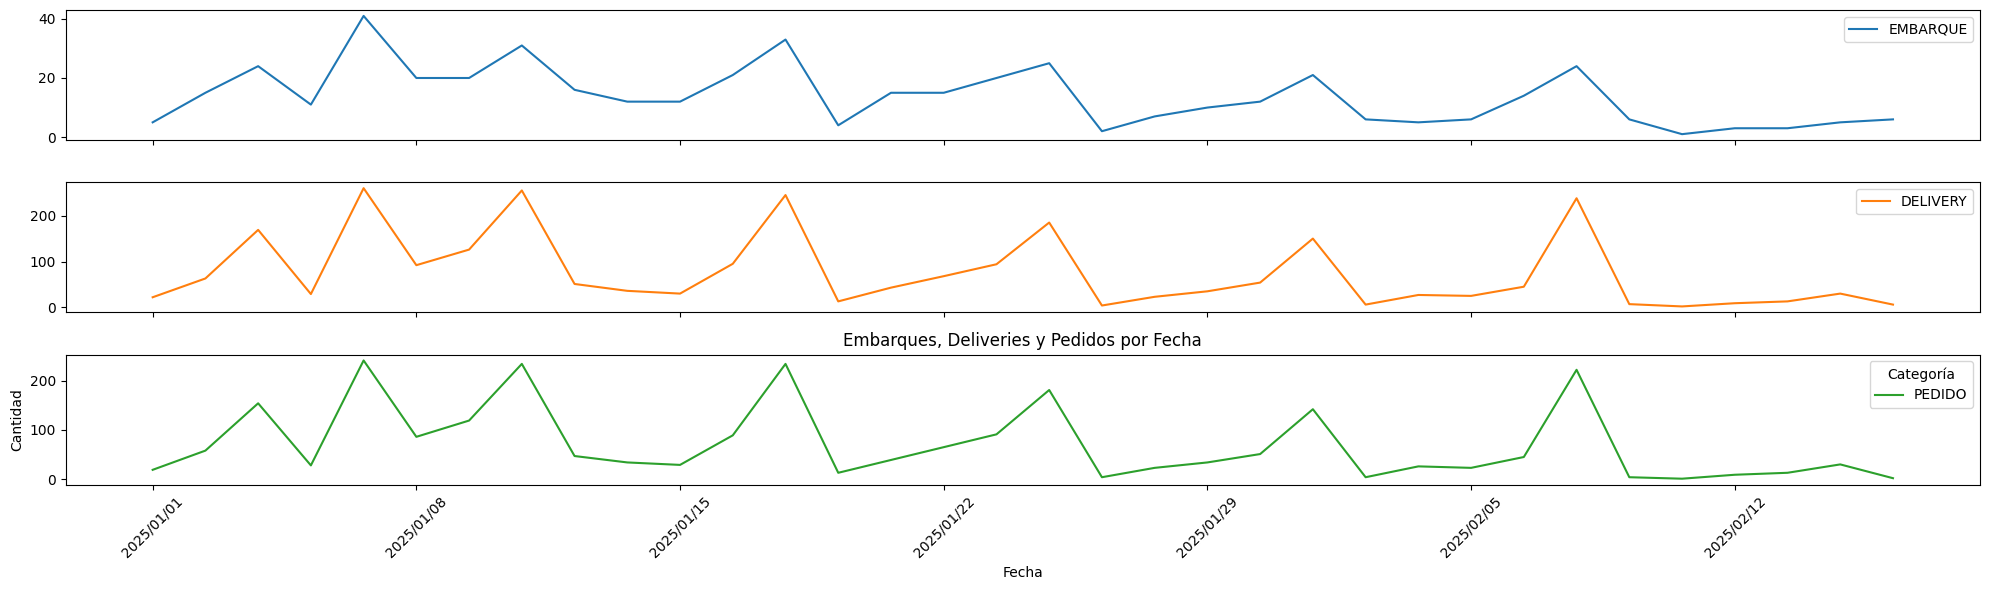

In [10]:
# Creación del gráfico
import matplotlib.pyplot as plt

# Asegurarnos de que el índice es de tipo fecha
# df.index = pd.to_datetime(df.index)

# Crear la gráfica de barras agrupadas
ax = df_completo.plot(kind='line',subplots=True, figsize=(20, 6))

# Añadir etiquetas y título
plt.title('Embarques, Deliveries y Pedidos por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Categoría')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


### CONTADORES AGRUPADOS

C:\Users\eduar\AppData\Local\Temp\ipykernel_8188\862587174.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_completo.resample('M').sum()


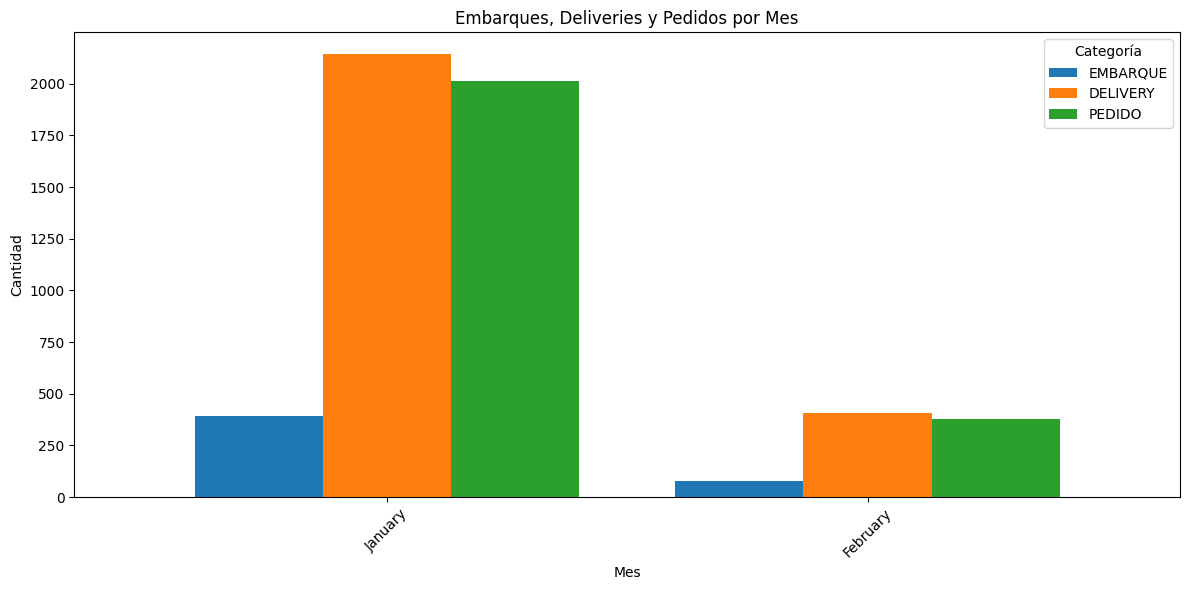

In [11]:
# GENERAR Dataframes Acumulado MENSUAL
# Asegurarnos de que el índice es de tipo fecha
df_completo.index = pd.to_datetime(df_completo.index)

# Agrupar por mes y calcular la suma de cada mes
df_monthly = df_completo.resample('M').sum()

# Añadir una columna con el nombre del mes
df_monthly['Mes'] = df_monthly.index.strftime('%B')

# Ajustar el índice para que sea el nombre del mes
df_monthly.set_index('Mes', inplace=True)

# Crear la gráfica de barras agrupadas por mes
ax = df_monthly.plot(kind='bar', figsize=(12, 6), width=0.8)

# Añadir etiquetas y título
plt.title('Embarques, Deliveries y Pedidos por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Categoría')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [12]:
# OTRA FORMA para GENERAR Dataframes Acumulado MENSUAL
TOT_embarque = df.groupby('LogisticGroupId')['EMBARQUE'].nunique()
TOT_delivery = df.groupby('LogisticGroupId')['DELIVERY'].nunique()
TOT_pedido = df.groupby('LogisticGroupId')['PEDIDO'].nunique()

EMBARQUE     471
DELIVERY    2550
PEDIDO      2394
dtype: int64


C:\Users\eduar\AppData\Local\Temp\ipykernel_8188\3351370405.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_completo.resample('M').sum()


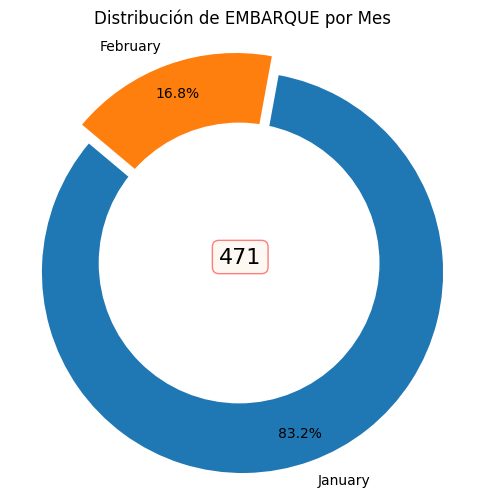

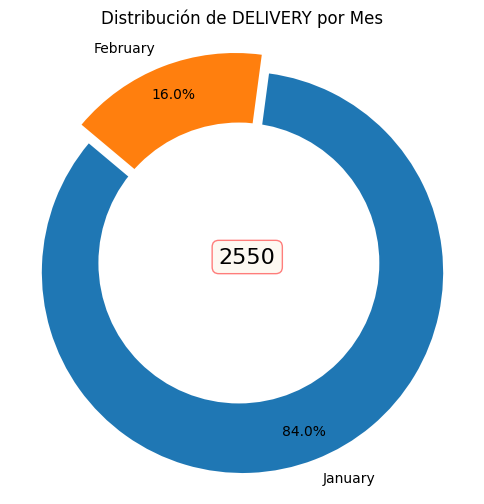

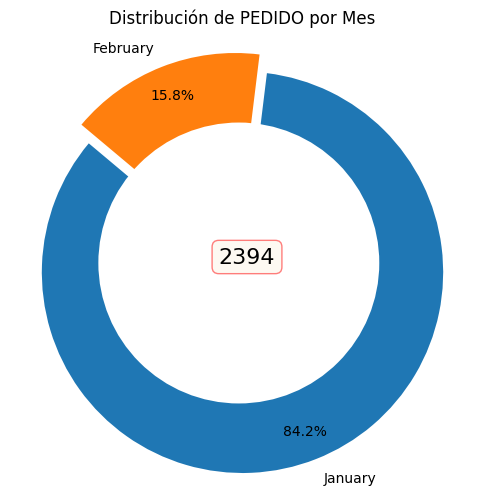

In [13]:
# GRAFICOS de ANILLOS
# https://barcelonageeks.com/grafico-de-anillos-usando-matplotlib-en-python/


import matplotlib.pyplot as plt

# Agrupar por mes y calcular la suma de cada mes
df_monthly = df_completo.resample('M').sum()

# Añadir una columna con el nombre del mes
df_monthly['Mes'] = df_monthly.index.strftime('%B')

# Crear un gráfico de pastel para cada categoría
categorias = ['EMBARQUE', 'DELIVERY', 'PEDIDO']

# Totales de las Categorías
print(df_monthly[categorias].sum())

for categoria in categorias:
    plt.figure(figsize=(6, 6))

    # Crear la lista 'explode' con el mismo tamaño que la cantidad de meses
    explode = [0.05] * len(df_monthly)  

    plt.pie(df_monthly[categoria], labels=df_monthly['Mes'], autopct='%1.1f%%', 
            startangle=140, pctdistance=0.85, explode=explode)

    # Dibujar círculo para hacer gráfico de anillo
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Agregar Total en Cada Gráfico   
    plt.text(-0.1, 0, df_monthly[categoria].sum(), fontsize=16, 
             bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'boxstyle': "round,pad=0.3", 'ec': 'red'})

    plt.title(f'Distribución de {categoria} por Mes')
    plt.axis('equal')  # Para asegurar que el gráfico de pastel sea un círculo  
    plt.show()


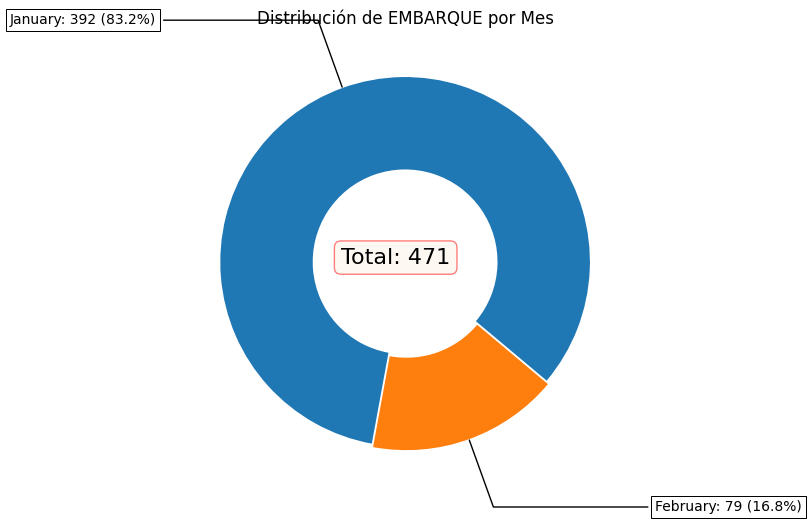

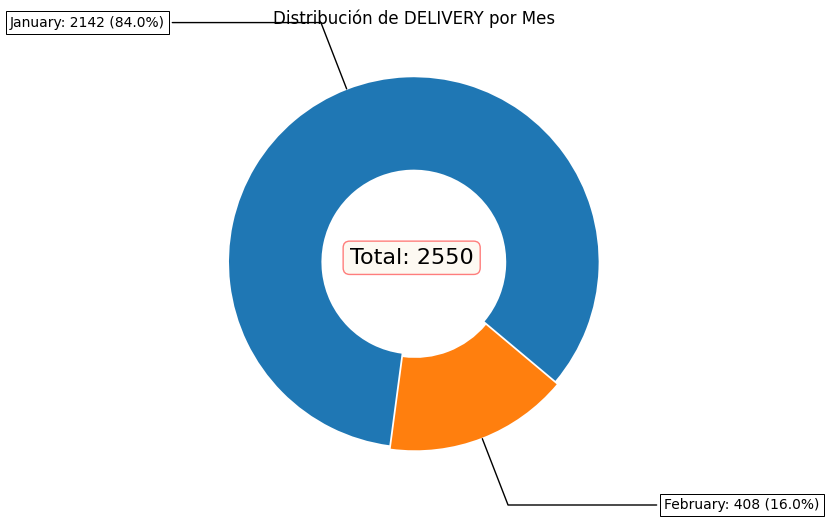

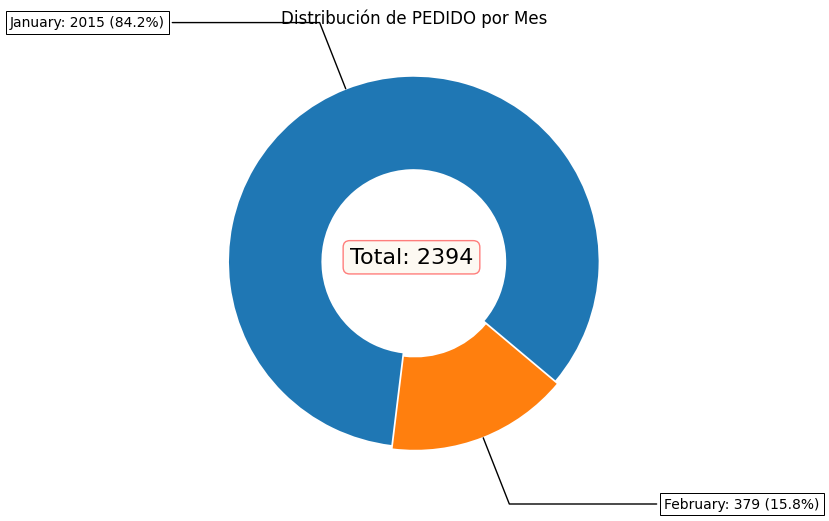

In [14]:
# VERSIÓN MEJORADA
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

import numpy as np
import matplotlib.pyplot as plt

# Agrupar por mes y calcular la suma de cada mes
df_monthly = df_completo.resample('ME').sum()

# Añadir una columna con el nombre del mes
df_monthly['Mes'] = df_monthly.index.strftime('%B')

# Crear un gráfico de pastel para cada categoría
categorias = ['EMBARQUE', 'DELIVERY', 'PEDIDO']

for categoria in categorias:   
    if categoria in df_monthly.columns:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

        # Configuración de explosión dinámica según la cantidad de meses
        explode = [0.01] * len(df_monthly[categoria])
        
        wedges, texts = ax.pie(df_monthly[categoria], wedgeprops=dict(width=0.5), startangle=-40, explode=explode)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"),
                bbox=bbox_props, zorder=0, va="center")

        total = df_monthly[categoria].sum()
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})

            porcentaje = df_monthly[categoria].iloc[i] / total * 100
            texto_anotacion = f'{df_monthly["Mes"].iloc[i]}: {df_monthly[categoria].iloc[i]} ({porcentaje:.1f}%)'
            ax.annotate(texto_anotacion, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)

        ax.set_title(f'Distribución de {categoria} por Mes')
        
        # Agregar Total en Cada Gráfico   
        plt.text(-0.35, 0, f'Total: {total}', fontsize=16, bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'boxstyle': "round,pad=0.3", 'ec': 'red'})

        plt.show()

In [15]:
# AGRUPAR por GRUPO LOGÍSTICO

# OTRA FORMA para GENERAR Dataframes Acumulado MENSUAL
dfa_embarque = df.groupby('LogisticGroupId')['EMBARQUE'].nunique()
dfa_delivery = df.groupby('LogisticGroupId')['DELIVERY'].nunique()
dfa_pedido = df.groupby('LogisticGroupId')['PEDIDO'].nunique()

# CONTATENAR Dataframes
dfa_completo = pd.merge(dfa_embarque, dfa_delivery, on='LogisticGroupId', how = 'outer')
dfa_completo = pd.merge(dfa_completo, dfa_pedido, on='LogisticGroupId', how = 'outer')

dfa_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, BAYER to Monsanto
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   EMBARQUE  2 non-null      int64
 1   DELIVERY  2 non-null      int64
 2   PEDIDO    2 non-null      int64
dtypes: int64(3)
memory usage: 64.0+ bytes


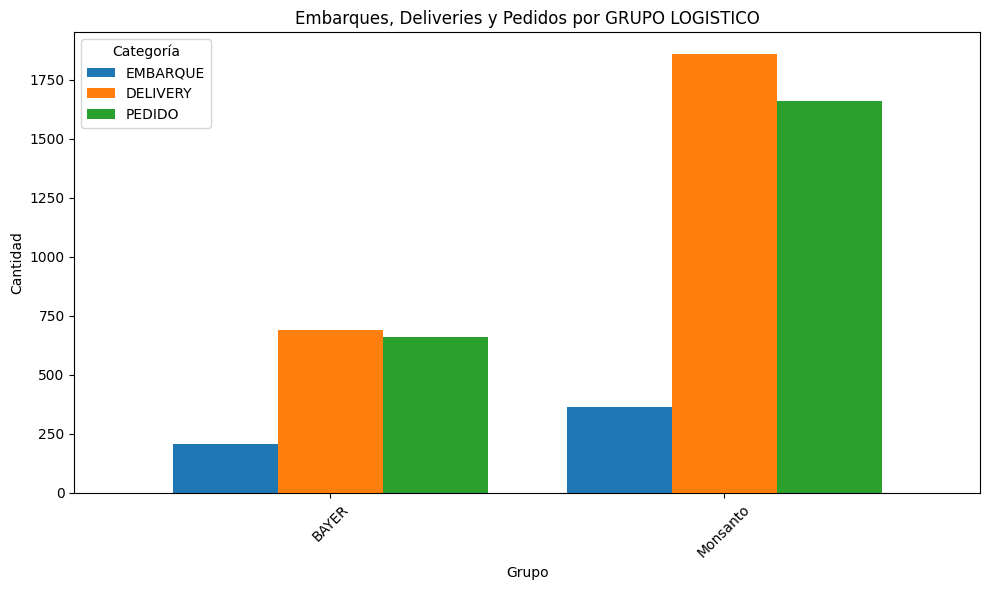

In [16]:
# Creación del gráfico
import matplotlib.pyplot as plt

# Asegurarnos de que el índice es de tipo fecha
# df.index = pd.to_datetime(df.index)

# Crear la gráfica de barras agrupadas
axa = dfa_completo.plot(kind='bar', figsize=(10, 6), width=0.8)

# Añadir etiquetas y título
plt.title('Embarques, Deliveries y Pedidos por GRUPO LOGISTICO')
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Categoría')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

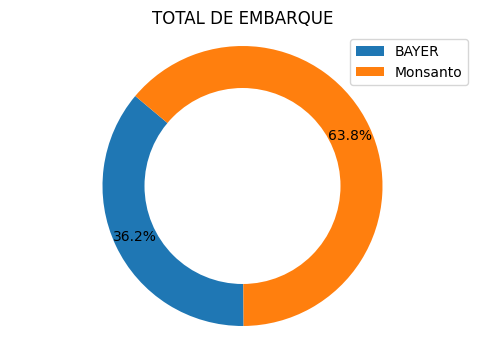

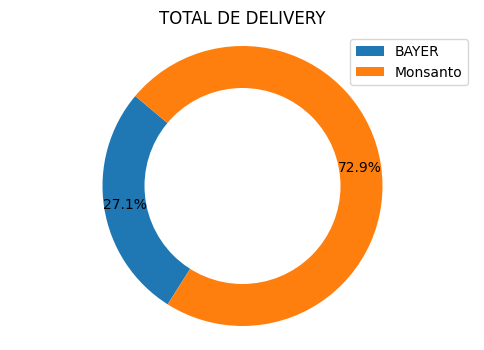

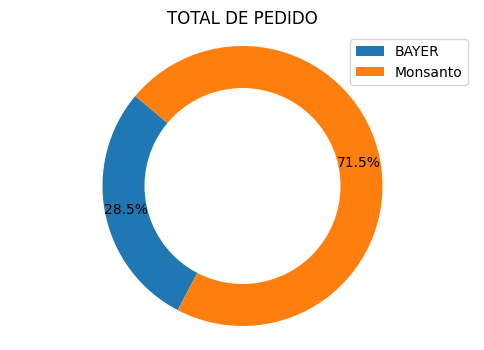

In [17]:
# Transponer el DataFrame para tener 'GrupoId' como columnas
df_transposed = dfa_completo.T

# Crear un gráfico de pastel para cada categoría
categorias = ['EMBARQUE', 'DELIVERY', 'PEDIDO']

# explosion
explode = (0.05, 0.05, 0.05)

for group in df_transposed.index:
    plt.figure(figsize=(6, 4))
    #plt.pie(df_transposed.loc[group], labels=df_transposed.columns, autopct='%1.1f%%', pctdistance=0.85, startangle=140)
    plt.pie(df_transposed.loc[group], autopct='%1.1f%%', pctdistance=0.85, startangle=140)
    # draw circle
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    # Adding Circle in Pie chart
    
    fig.gca().add_artist(centre_circle)
    plt.title(f'TOTAL DE {group}')
    plt.axis('equal')  # Para asegurar que el gráfico de pastel sea un círculo
    # Add Legends
    plt.legend(df_transposed.columns, loc="upper right")
    
    plt.show()

In [19]:
# Crear un gráfico de pastel para cada categoría



In [39]:
#Para hacerlo, puedes utilizar el método dt.strftime('%Y-%m-%d') del objeto datetime para formatar las fechas en el fmt "Año-Mes-Día" y luego contar la cantidad de valores distintos en la columna 'FECHA'.




In [40]:
#Para hacerlo, puedes utilizar el método dt.strftime('%Y-%m-%d') del objeto datetime para formatar las fechas en el fmt "Año-Mes-Día" y luego contar la cantidad de valores distintos en la columna 'FECHA'.


